In [24]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
runs = {
    'PL': mlflow.search_runs(experiment_names=['adult_PL'], order_by=['start_time DESC'])[:4],
    'STC': mlflow.search_runs(experiment_names=['adult_STC'], order_by=['start_time DESC'])[:4],
    'CC': mlflow.search_runs(experiment_names=['adult_CC'], order_by=['start_time DESC'])[:4],
    'HLNC': mlflow.search_runs(experiment_names=['adult_HLNC'], order_by=['start_time DESC'])[:4],
    'OBNC': mlflow.search_runs(experiment_names=['adult_OBNC'], order_by=['start_time DESC'])[:4]
}

In [16]:
runs['PL'].columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.demographic_parity_difference', 'metrics.accuracy',
       'metrics.equalized_odds_difference', 'params.correction_alg',
       'params.classifier', 'params.dataset', 'params.correction_classifier',
       'params.senstive_attr', 'params.test_size', 'params.columns',
       'params.n_folds', 'params.train_set', 'params.test_set',
       'tags.train_set', 'tags.run', 'tags.mlflow.source.name',
       'tags.mlflow.user', 'tags.mlflow.source.type',
       'tags.mlflow.source.git.commit', 'tags.test_set',
       'tags.mlflow.runName'],
      dtype='object')

In [93]:
def get_metric(metric):
    df = pd.DataFrame(columns=['noisy train/noisy test', 'corrected train/noisy test', 'noisy train/corrected test','corrected train/corrected test'])

    for key in runs:
        res = []
        for test_set in ['noisy', 'corrected']:
            for train_set in ['noisy', 'corrected']:
                res.append(runs[key].loc[(runs[key]['tags.train_set'] == train_set) & (runs[key]['tags.test_set'] == test_set), f'metrics.{metric}'].values[0])
        df.loc[key] = res

    return df

In [94]:
metrics = {
    'accuracy': get_metric('accuracy'),
    'demographic_parity': get_metric('demographic_parity_difference'),
    'equalized_odds': get_metric('equalized_odds_difference')
}
names = ['accuracy', 'demographic_parity', 'equalized_odds']

In [96]:
metrics['accuracy']

,noisy train/noisy test,corrected train/noisy test,noisy train/corrected test,corrected train/corrected test
PL,0.790633,0.790531,1.000000,0.999898
STC,0.790633,0.792683,0.956446,0.958496
CC,0.790633,0.790121,0.953372,0.990777
HLNC,0.790633,0.775159,0.939947,0.984526
OBNC,0.790633,0.790531,0.790838,0.790736


In [97]:
metrics['demographic_parity']

,noisy train/noisy test,corrected train/noisy test,noisy train/corrected test,corrected train/corrected test
PL,0.04483,0.044676,0.04483,0.044676
STC,0.04483,0.044520,0.04483,0.044520
CC,0.04483,0.025640,0.04483,0.025640
HLNC,0.04483,0.012973,0.04483,0.012973
OBNC,0.04483,0.044676,0.04483,0.044676


In [98]:
metrics['equalized_odds']

,noisy train/noisy test,corrected train/noisy test,noisy train/corrected test,corrected train/corrected test
PL,0.02585,0.026343,0.000000,0.001479
STC,0.02585,0.022893,0.104824,0.097073
CC,0.02585,0.033575,0.019082,0.023266
HLNC,0.02585,0.036487,0.027125,0.114492
OBNC,0.02585,0.026343,0.026486,0.026979


In [85]:
def ax_show_metric(ax:plt.Axes, results_df, metric, baseline, train_test_set):
    ax.scatter(results_df.index, results_df[train_test_set])
    for i, v in enumerate(results_df[train_test_set]):
        ax.text(i+0.3, v-0.001, "{:.4f}".format(v), ha="center")
    ax.plot(results_df.index, results_df[baseline], color='red', linestyle='dashed', label=baseline)
    ax.set_title(f'{metric}')

In [88]:
def show_metrics(baseline, train_test_set):
    fig = plt.figure(figsize=(21, 5))

    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1)
        ax_show_metric(ax, metrics[names[i]], names[i], baseline, train_test_set)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    fig.suptitle(f'Results on {train_test_set}')
    plt.show()

### Results on noisy test set

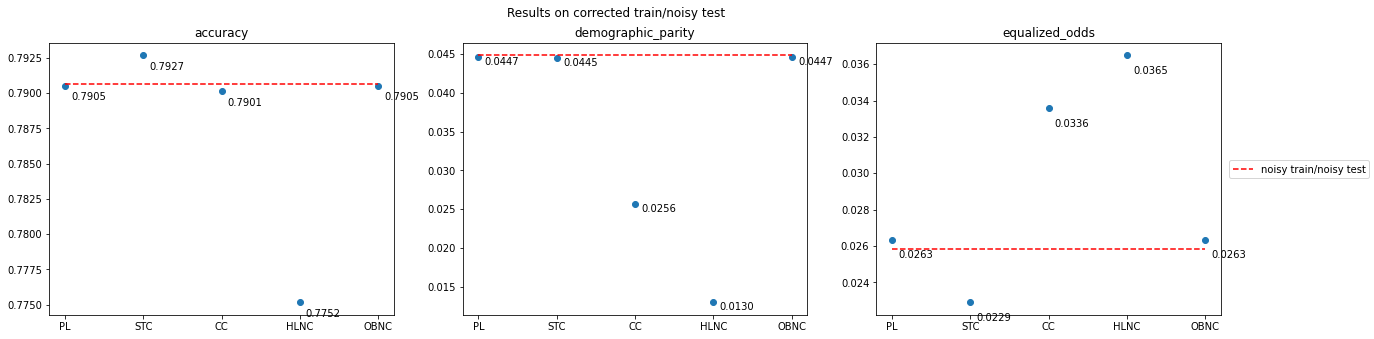

In [89]:
show_metrics('noisy train/noisy test', 'corrected train/noisy test')

### Results on corrected test set

#### Correcting only the test set

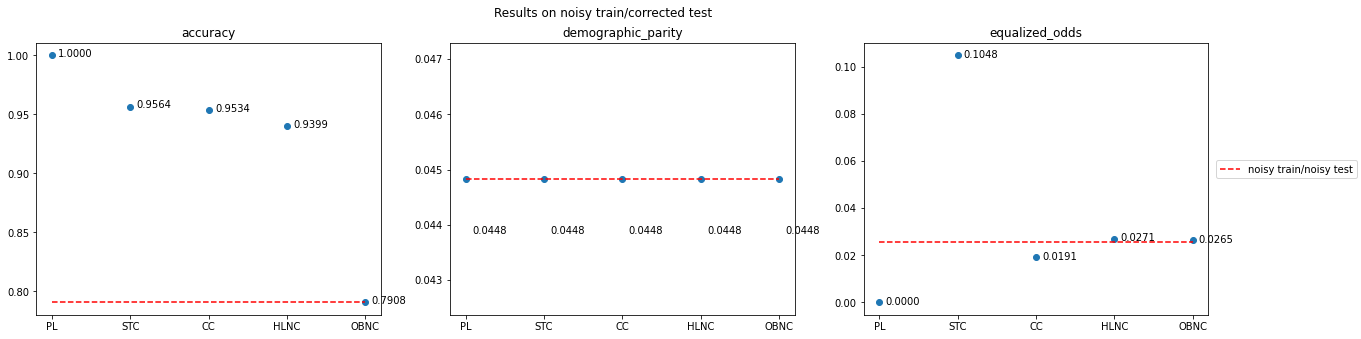

In [90]:
show_metrics('noisy train/noisy test', 'noisy train/corrected test')

#### Correcting both train and test sets

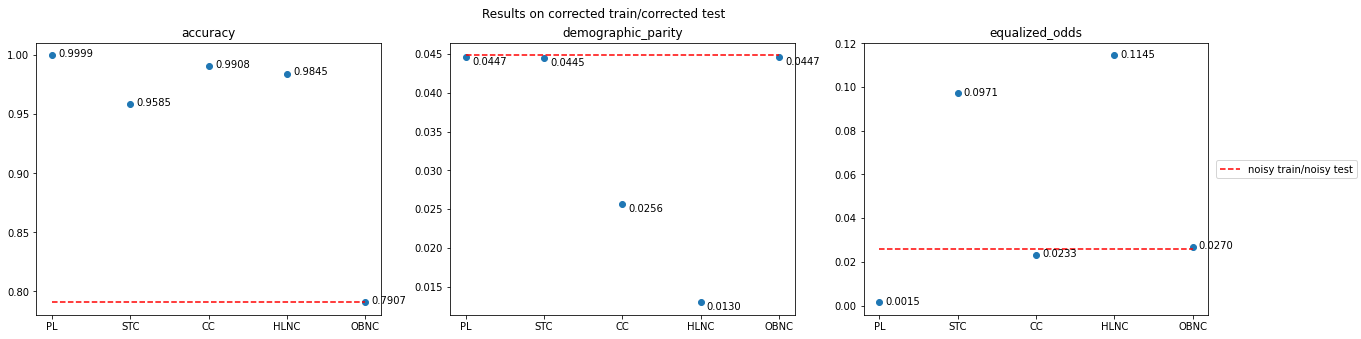

In [91]:
show_metrics('noisy train/noisy test', 'corrected train/corrected test')

#### Using only corrected test set, correcting the train set

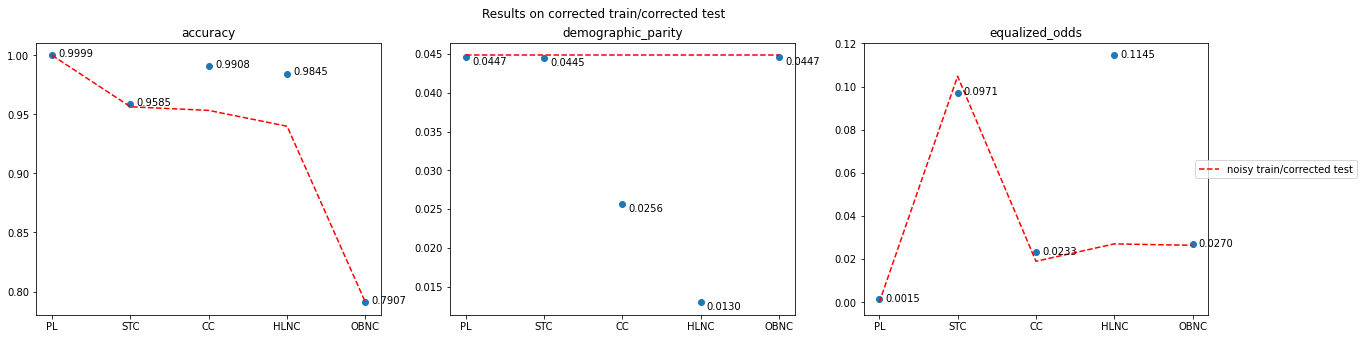

In [92]:
show_metrics('noisy train/corrected test', 'corrected train/corrected test')